# Customer Segmentation using K-Means Clustering

## Assignment Summary
Tugas ini bertujuan untuk melakukan segmentasi pelanggan menggunakan algoritma K-Means Clustering berdasarkan pola perjalanan pelanggan dalam industri penerbangan.

### Tools & Dataset
- Tools: Python, Google Colaboratory, Scikit-learn, Seaborn, Matplotlib
- Dataset: [https://drive.google.com/file/d/1BC8oxajBeD3GGtlYkUNoc7dHHbOLFbcm/view?usp=drive_link](#)

### Metode
- Feature Selection (RFM: Recency, Frequency, Monetary)
- Standardisasi
- K-Means Clustering
- Evaluasi dengan Elbow & Silhouette Score
- Visualisasi dengan PCA

### Ringkasan Hasil
Clustering membagi pelanggan menjadi beberapa kelompok utama seperti pelanggan VIP, pelanggan churn, dan pelanggan potensial baru.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


## Data Understanding

In [ ]:
df = pd.read_csv('flight.csv')


df.head()

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,54993,11/2/2006,12/24/2008,Male,6,.,beijing,CN,31.0,3/31/2014,...,234188.0,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50
1,28065,2/19/2007,8/3/2007,Male,6,NaN,beijing,CN,42.0,3/31/2014,...,167434.0,293678,3/25/2014,7,5.194245,17,29,1.252314,415768,33
2,55106,2/1/2007,8/30/2007,Male,6,.,beijing,CN,40.0,3/31/2014,...,164982.0,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26
3,21189,8/22/2008,8/23/2008,Male,5,Los Angeles,CA,US,64.0,3/31/2014,...,125500.0,281336,12/26/2013,97,27.863636,73,11,1.090870,372204,12
4,39546,4/10/2009,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,3/31/2014,...,130702.0,309928,3/27/2014,5,4.788079,47,27,0.970658,338813,39


In [ ]:
df['MEMBER_NO'].value_counts()

,count
MEMBER_NO,
61340,1
54993,1
28065,1
55106,1
21189,1
...,...
8253,1
1254,1
57881,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEMBER_NO          62988 non-null  int64  
 1   FFP_DATE           62988 non-null  object 
 2   FIRST_FLIGHT_DATE  62988 non-null  object 
 3   GENDER             62985 non-null  object 
 4   FFP_TIER           62988 non-null  int64  
 5   WORK_CITY          60719 non-null  object 
 6   WORK_PROVINCE      59740 non-null  object 
 7   WORK_COUNTRY       62962 non-null  object 
 8   AGE                62568 non-null  float64
 9   LOAD_TIME          62988 non-null  object 
 10  FLIGHT_COUNT       62988 non-null  int64  
 11  BP_SUM             62988 non-null  int64  
 12  SUM_YR_1           62437 non-null  float64
 13  SUM_YR_2           62850 non-null  float64
 14  SEG_KM_SUM         62988 non-null  int64  
 15  LAST_FLIGHT_DATE   62988 non-null  object 
 16  LAST_TO_END        629

# build dataset

### RFM Feature Explanation
Fitur `Recency`, `Frequency`, dan `Monetary` tidak tersedia secara langsung dalam dataset asli.
Fitur ini dihitung berdasarkan:
- `Recency`: menggunakan `LAST_TO_END`
- `Frequency`: jumlah penerbangan (`FLIGHT_COUNT`)
- `Monetary`: jumlah poin dari `Points_Sum`

Tujuan dari transformasi ini adalah untuk memahami perilaku pelanggan dalam hal seberapa sering, baru, dan bernilai aktivitas penerbangan mereka.


In [ ]:
# Buat DataFrame baru untuk RFM
rfm = df[['MEMBER_NO', 'LAST_TO_END', 'FLIGHT_COUNT', 'Points_Sum']].copy()

# Ganti nama kolom agar sesuai konsep RFM
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [ ]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,54993,1,210,619760
1,28065,7,140,415768
2,55106,11,135,406361
3,21189,97,23,372204
4,39546,5,152,338813


### Drop missing value

In [ ]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   CustomerID  62988 non-null  int64
 1   Recency     62988 non-null  int64
 2   Frequency   62988 non-null  int64
 3   Monetary    62988 non-null  int64
dtypes: int64(4)
memory usage: 1.9 MB


In [ ]:
rfm.isnull().sum()

,0
CustomerID,0
Recency,0
Frequency,0
Monetary,0


In [ ]:
rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,62988.000000,62988.000000,62988.000000,62988.0000
mean,31494.500000,176.120102,11.839414,12545.7771
std,18183.213715,183.822223,14.049471,20507.8167
min,1.000000,1.000000,2.000000,0.0000
25%,15747.750000,29.000000,3.000000,2775.0000
50%,31494.500000,108.000000,7.000000,6328.5000
75%,47241.250000,268.000000,15.000000,14302.5000
max,62988.000000,731.000000,213.000000,985572.0000


### Drop duplicates

In [ ]:
rfm.duplicated().sum()

np.int64(0)

### Feature Selection

In [ ]:
feat = ['Recency','Frequency','Monetary']
dataset = rfm[feat].copy()

## Modeling and Evaluation

### Scaling

In [ ]:
# Scaling
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

In [ ]:
feats = list(dataset)
new_df = pd.DataFrame(data = rfm_scaled, columns = feats)
new_df.head()

,Recency,Frequency,Monetary
0,-0.952668,14.104600,29.609151
1,-0.920027,9.122166,19.662036
2,-0.898267,8.766278,19.203329
3,-0.430420,0.794384,17.537756
4,-0.930907,9.976297,15.909534


### Inertia

<Axes: >

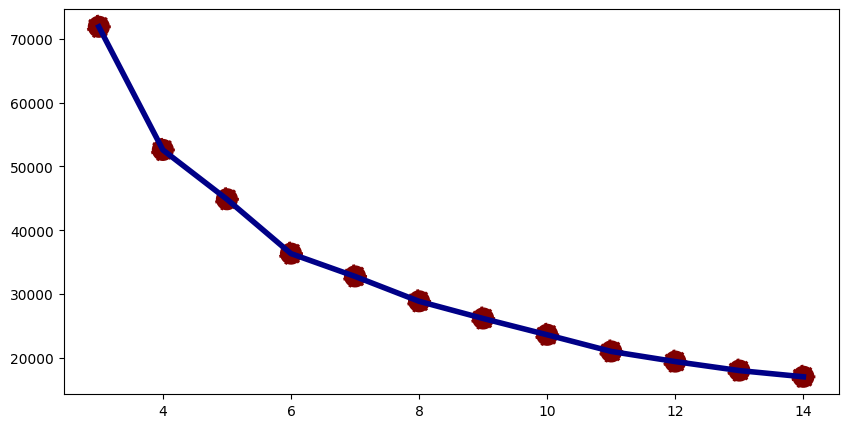

In [ ]:
from sklearn.cluster import KMeans
inertia = []

for i in range(3, 15):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))

sns.lineplot(x=range(3, 15), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(3, 15), y=inertia, s=300, color='#800000',  linestyle='--')


## Silhouette score

In [ ]:
range_n_clusters = list(range(3,15))
print(range_n_clusters)

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [ ]:
arr_silhouette_score_euclidean = []
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i).fit(rfm_scaled)
    preds = kmeans.predict(new_df)

    score_euclidean = silhouette_score(new_df, preds, metric='euclidean')
    arr_silhouette_score_euclidean.append(score_euclidean)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KMeans was fitted without feature names
  w

<Axes: >

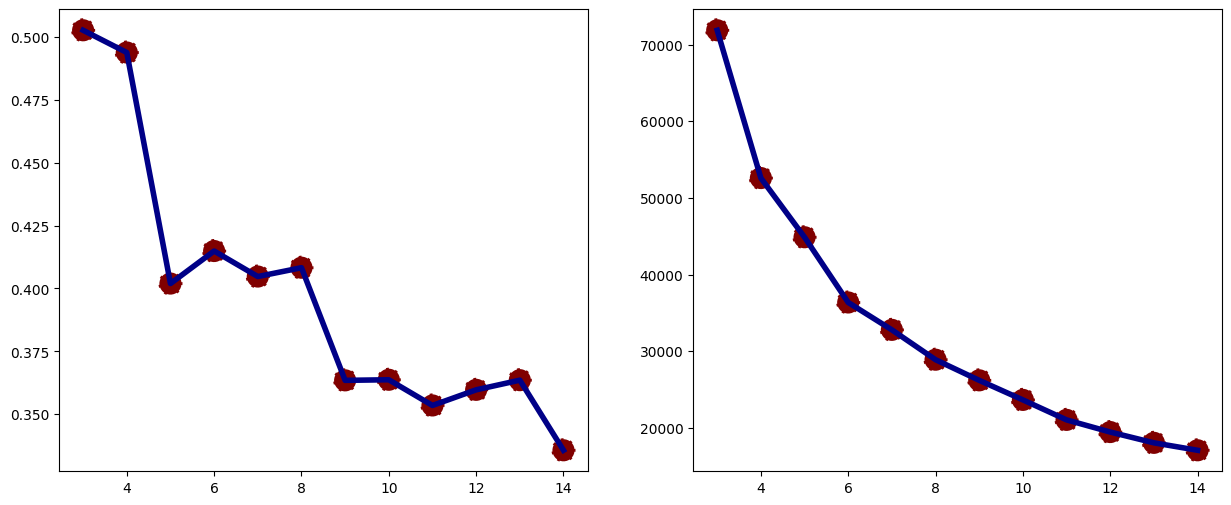

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15, 6))
sns.lineplot(x=range(3,15), y=arr_silhouette_score_euclidean, color='#000087', linewidth = 4, ax=ax[0])
sns.scatterplot(x=range(3,15), y=arr_silhouette_score_euclidean, s=300, color='#800000',  linestyle='--',ax=ax[0])

sns.lineplot(x=range(3, 15), y=inertia, color='#000087', linewidth = 4,ax=ax[1])
sns.scatterplot(x=range(3, 15), y=inertia, s=300, color='#800000',  linestyle='--', ax=ax[1])

In [ ]:
## Candidat clustering 5 dan 9

### Clustering

In [ ]:
kmeans = KMeans(n_clusters=8, random_state=0)
kmeans.fit(new_df)

KMeans(random_state=0)

In [ ]:
dataset['clusters'] = kmeans.labels_
dataset.head()

,Recency,Frequency,Monetary,clusters
0,1,210,619760,4
1,7,140,415768,4
2,11,135,406361,4
3,97,23,372204,4
4,5,152,338813,4


In [ ]:
perc = [0.1,0.2,0.3,00.4,0.5,0.6,0.7,0.8,0.9]
dataset.describe(percentiles=perc)

,Recency,Frequency,Monetary,clusters
count,62988.000000,62988.000000,62988.0000,62988.000000
mean,176.120102,11.839414,12545.7771,3.042151
std,183.822223,14.049471,20507.8167,2.381092
min,1.000000,2.000000,0.0000,0.000000
10%,9.000000,2.000000,1407.0000,0.000000
20%,21.000000,3.000000,2300.0000,1.000000
30%,39.000000,4.000000,3336.2000,1.000000
40%,70.000000,5.000000,4635.0000,1.000000
50%,108.000000,7.000000,6328.5000,3.000000
60%,155.000000,9.000000,8649.2000,3.000000


In [ ]:
dataset.groupby('clusters').agg({
                            'Recency' : ['median'],
                            'Frequency' : ['mean'],
                            'Monetary' : ['mean']

})

,Recency,Frequency,Monetary
,median,mean,mean
clusters,,,
0,577.0,3.162154,3434.488782
1,44.0,7.356293,6613.404885
2,15.0,40.567335,44228.165668
3,188.0,5.733426,5566.395252
4,11.0,72.185897,235165.538462
5,368.0,4.765846,4816.062671
6,7.0,72.140670,90710.822967
7,33.0,20.749772,20728.991258


## Clustering Analysis

In [ ]:
# 0 : Lost customer (churn)
# 1 : Normal user potensial
# 2 : New user sangat potensial
# 3 : User biasa
# 4 : VIP / High value customer
# 5 : Old user tidak berpotensi
# 6 : New user sangat potensial
# 7 : New user butuh perhatian

# cluster bagus


## Viz Clustering with PCA - Optional

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

pca.fit(rfm_scaled)
pcs = pca.transform(rfm_scaled)

data_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])
data_pca['clusters'] = dataset['clusters']
data_pca.head()

,PC 1,PC 2,clusters
0,27.859962,14.403079,4
1,18.470702,9.257155,4
2,17.947057,9.010473,4
3,11.549080,7.012621,4
4,16.708321,7.887280,4


<Axes: xlabel='PC 1', ylabel='PC 2'>

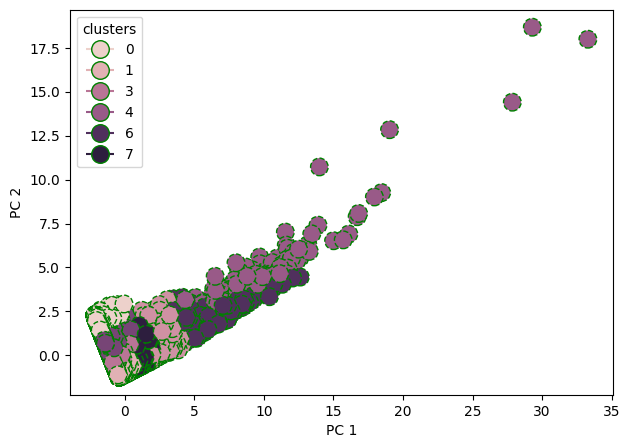

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

sns.scatterplot(
    x="PC 1", y="PC 2",
    hue="clusters",
    edgecolor='green',
    linestyle='--',
    data=data_pca,
    s=160,
    ax=ax
)

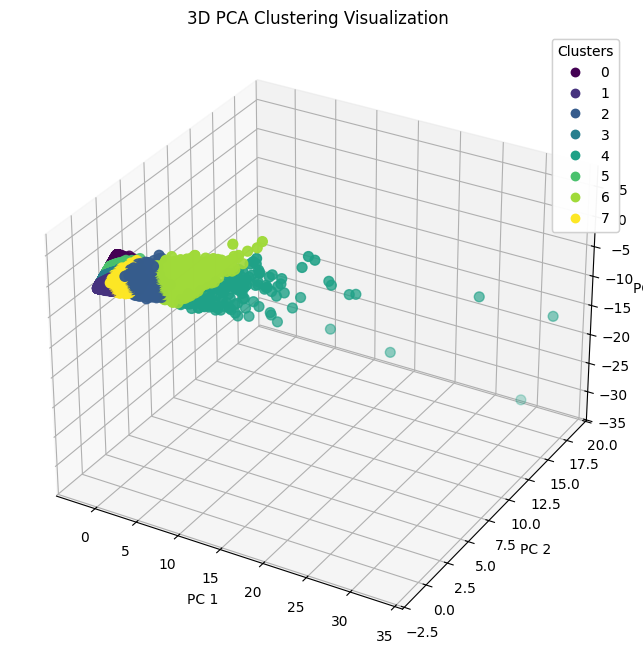

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)

pca.fit(rfm_scaled)
pcs = pca.transform(rfm_scaled)

data_pca_3d = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2', 'PC 3'])
data_pca_3d['clusters'] = dataset['clusters']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(data_pca_3d['PC 1'], data_pca_3d['PC 2'], data_pca_3d['PC 3'],
                     c=data_pca_3d['clusters'], cmap='viridis', s=50)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('3D PCA Clustering Visualization')

# Add a color bar
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.show()

## Business Insight dan Rekomendasi per Cluster

Berdasarkan hasil clustering, berikut adalah karakteristik dan rekomendasi strategi:

- **Cluster 0 (Lost Customer / Churn):**
  - Recency tinggi, Frequency rendah, Monetary rendah
  - Rekomendasi: kirimkan penawaran khusus atau diskon untuk menarik kembali

- **Cluster 1 (Potensial Normal User):**
  - Keseimbangan RFM
  - Rekomendasi: kembangkan engagement lewat program loyalitas

- **Cluster 2 & 6 (New User Sangat Potensial):**
  - Recency rendah (baru), tapi frequency dan monetary mulai tinggi
  - Rekomendasi: perkuat onboarding dan promosi awal

- **Cluster 4 (VIP / High Value Customer):**
  - Semua metrik tinggi
  - Rekomendasi: berikan layanan eksklusif dan program loyalitas prioritas

- **Cluster 5 (Old User Tidak Berpotensi):**
  - Tidak aktif, historis tinggi
  - Rekomendasi: tidak perlu alokasi biaya pemasaran lebih lanjut

- **Cluster 7 (New User Butuh Perhatian):**
  - Baru, tapi belum menunjukkan potensi
  - Rekomendasi: kirim welcome campaign dan edukasi fitur
